Import and format the vtt data

In [1]:

import webvtt
import re
import pandas as pd


file_name = "data/example_transcripts.vtt"

with open(file_name) as file:
	vtt_content = file.read()

# print(vtt_content)
# Function to format the time stamps
def format_time_stamp(time_stamp):
    # Match the time stamp pattern
    match = re.match(r"(\d+):(\d+):(\d+)\.(\d+) --> (\d+):(\d+):(\d+)\.(\d+)", time_stamp)
    if match:
        # Extract the individual components of the time stamp
        hours1, minutes1, seconds1, milliseconds1 = map(int, match.groups()[:4])
        hours2, minutes2, seconds2, milliseconds2 = map(int, match.groups()[4:])

        # Format the time stamps
        formatted_time1 = f"{hours1:03d}:{minutes1:02d}:{seconds1:02d}.{milliseconds1:03d}"
        formatted_time2 = f"{hours2:03d}:{minutes2:02d}:{seconds2:02d}.{milliseconds2:03d}"

        # Combine the formatted time stamps
        return f"{formatted_time1} --> {formatted_time2}"
    else:
        return time_stamp

# Process the .vtt file content
formatted_content = "\n".join(
    format_time_stamp(line) if "-->" in line else line
    for line in vtt_content.splitlines()
)


# Save the formatted content to a new .vtt file
with open("data/formatted_output.vtt", "w", encoding="utf-8") as file:
    file.write(formatted_content)
    
formatted_output = 'data/formatted_output.vtt'

print()
print("Formatted .vtt file saved as '" + formatted_output + "'.")
print()

import webvtt
start=[]
end=[]
text=[]
speaker=[]
for caption in webvtt.read(formatted_output):
    start.append(caption.start)
    end.append(caption.end)
    text.append(caption.text)
    speaker.append(caption.raw_text)


df = pd.DataFrame(list(zip(start,end,text,speaker)), columns = ['StartTime', 'EndTime',"Text","Speaker"])
listx=df['Speaker'].str.split('>', n=1, expand=True)
df["Speaker"]=listx[0]
df["Speaker"]=df["Speaker"].str.replace("<v ","")
# print(df.head())



Formatted .vtt file saved as 'data/formatted_output.vtt'.



Generate the timeline

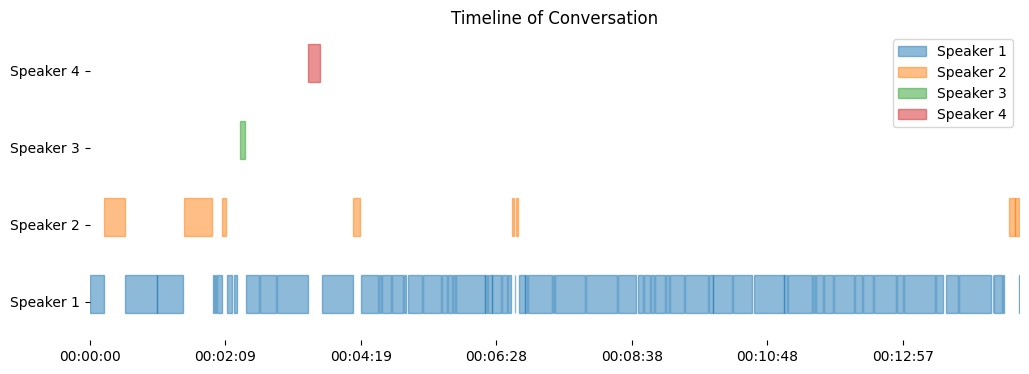

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from matplotlib.dates import DateFormatter
from vtt_formatting import df

def create_timeline_figure(df):
    # Convert the time columns to datetime objects
    df['StartTime'] = pd.to_datetime(df['StartTime'], format='%H:%M:%S.%f')
    df['EndTime'] = pd.to_datetime(df['EndTime'], format='%H:%M:%S.%f')
    
    # Get the unique speakers and sort them
    speakers = df['Speaker'].unique()
    speakers = sorted(speakers)

    # Calculate the figure height based on the number of speakers
    # Base height per speaker plus some padding
    base_height_per_speaker = 1  # Adjust this based on your needs
    fig_height = len(speakers) * base_height_per_speaker
    
    # Create the figure and axis with dynamic height
    fig, ax = plt.subplots(figsize=(12, fig_height))
    
    # Remove the spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)  # Optional
    ax.spines['left'].set_visible(False)   # Optional
    
    # Calculate the y-position for each speaker
    speaker_positions = {speaker: i for i, speaker in enumerate(speakers)}
    
    # Keep track of patches for legend
    legend_patches = []
    
    # Plot the turns for each speaker
    for speaker in speakers:
        speaker_df = df[df['Speaker'] == speaker]
        color = f'C{speaker_positions[speaker]}'
        for _, row in speaker_df.iterrows():
            start = row['StartTime']
            end = row['EndTime']
            ax.add_patch(patches.Rectangle((start, speaker_positions[speaker] - 0.15), end - start, 0.5, color=f'C{speaker_positions[speaker]}', alpha=0.5))
        # Add patch to legend list
        legend_patches.append(patches.Patch(color=color, label=speaker, alpha=0.5))
    
    # Add legend
    ax.legend(handles=legend_patches, loc='upper right')
    
    # Remove y-axis labels
    ax.set_yticks([])
    
    # Set the x-axis limits to the full conversation duration
    min_time = df['StartTime'].min()
    max_time = df['EndTime'].max()
    ax.set_xlim(min_time, max_time)
    
    # Set the y-axis limits and ticks
    ax.set_ylim(-0.5, len(speakers) - 0.5)
    ax.set_yticks(list(range(len(speakers))))
    ax.set_yticklabels(speakers)
    
    # Format the x-axis labels to show time
    time_format = DateFormatter('%H:%M:%S')
    ax.xaxis.set_major_formatter(time_format)
    
    # Optionally, increase the number of ticks if needed
    ax.xaxis.set_major_locator(MaxNLocator(nbins=10))
    
    # Add labels and title
    ax.set_title('Timeline of Conversation')
    
    return fig

# Usage
fig = create_timeline_figure(df)
plt.show()


Generate some stats

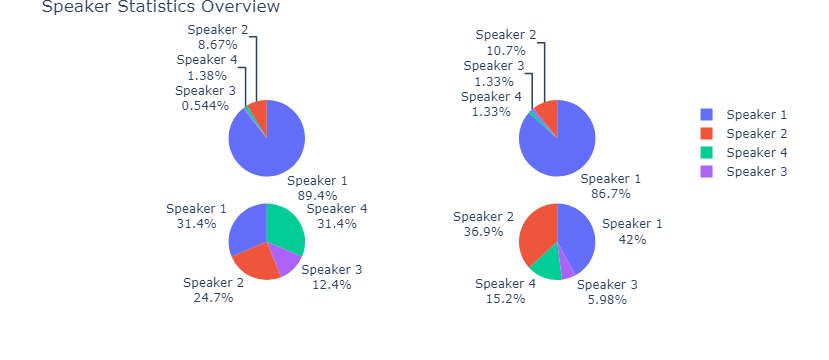

In [24]:
from vtt_formatting import df
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Assuming your dataframe is named 'df'
df = df.copy()

def create_stats_figure(df):
    # Convert the time columns to datetime objects
    df['StartTime'] = pd.to_datetime(df['StartTime'], format='%H:%M:%S.%f')
    df['EndTime'] = pd.to_datetime(df['EndTime'], format='%H:%M:%S.%f')

    # Calculate the duration of each turn in seconds
    df['Duration'] = (df['EndTime'] - df['StartTime']).dt.total_seconds()

    # Calculate the total duration of the conversation
    total_duration = df['Duration'].sum()

    # Calculate the percentage of talking time for each speaker
    speaker_durations = df.groupby('Speaker')['Duration'].sum()
    speaker_percentages = (speaker_durations / total_duration) * 100
    speaker_percentages = speaker_percentages.sort_values(ascending=False)

    # Calculate the number of turns for each speaker
    speaker_turns = df.groupby('Speaker')['Text'].count()
    speaker_turns = speaker_turns.sort_values(ascending=False)

    # Calculate the average length of turns for each speaker
    speaker_avg_turns = df.groupby('Speaker')['Duration'].mean()
    speaker_avg_turns = speaker_avg_turns.sort_values(ascending=False)

    # Calculate the longest run for each speaker
    speaker_longest_run = df.groupby('Speaker')['Duration'].max()
    speaker_longest_run = speaker_longest_run.sort_values(ascending=False)

    # Create subplots
    fig = make_subplots(rows=2, cols=2, specs=[[{'type':'domain'}, {'type':'domain'}],
                                                [{'type':'domain'}, {'type':'domain'}]])

    # Plot the percentage of talking time for each speaker
    fig.add_trace(go.Pie(labels=speaker_percentages.index, values=speaker_percentages, name="Percentage of Talk Time"),
                  1, 1)

    # Plot the number of turns for each speaker
    fig.add_trace(go.Pie(labels=speaker_turns.index, values=speaker_turns, name="Number of Turns"),
                  1, 2)

    # Plot the average length of turns for each speaker
    fig.add_trace(go.Pie(labels=speaker_avg_turns.index, values=speaker_avg_turns, name="Average Turn Length"),
                  2, 1)

    # Plot the longest run for each speaker
    fig.add_trace(go.Pie(labels=speaker_longest_run.index, values=speaker_longest_run, name="Longest Run"),
                  2, 2)

    # Update the layout and titles
    fig.update_layout(title_text='Speaker Statistics Overview', title_y=1)
    fig.update_traces(textinfo='percent+label')
    
    return fig

# Use this to display the figure in a Jupyter Notebook
fig = create_stats_figure(df)
fig.show()


Data Preparation for the pie charts

In [11]:
# Import necessary libraries
from vtt_formatting import df  # Importing the dataframe from your custom module
import pandas as pd
import plotly.graph_objects as go

# Assuming your dataframe is named 'df'
df = df.copy()

# Convert the time columns to datetime objects
df['StartTime'] = pd.to_datetime(df['StartTime'], format='%H:%M:%S.%f')
df['EndTime'] = pd.to_datetime(df['EndTime'], format='%H:%M:%S.%f')

# Calculate the duration of each turn in seconds
df['Duration'] = (df['EndTime'] - df['StartTime']).dt.total_seconds()

# Calculate the total duration of the conversation
total_duration = df['Duration'].sum()

# Calculate statistics
speaker_durations = df.groupby('Speaker')['Duration'].sum()
speaker_percentages = (speaker_durations / total_duration) * 100
speaker_percentages = speaker_percentages.sort_values(ascending=False)

speaker_turns = df.groupby('Speaker')['Text'].count()
speaker_turns = speaker_turns.sort_values(ascending=False)

speaker_avg_turns = df.groupby('Speaker')['Duration'].mean()
speaker_avg_turns = speaker_avg_turns.sort_values(ascending=False)

speaker_longest_run = df.groupby('Speaker')['Duration'].max()
speaker_longest_run = speaker_longest_run.sort_values(ascending=False)


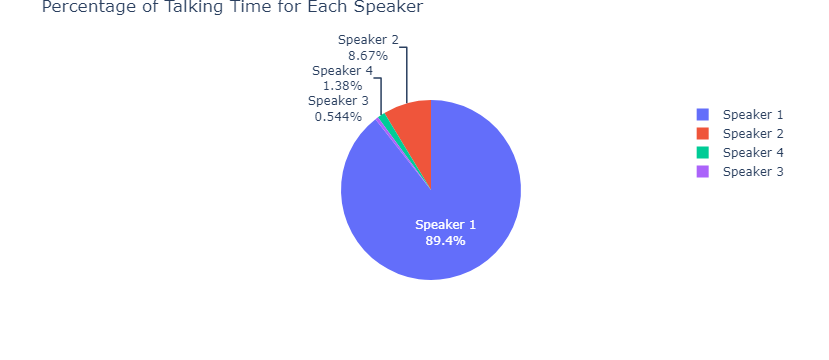

In [22]:
# Create the pie chart for percentage of talking time
fig = go.Figure(data=[go.Pie(labels=speaker_percentages.index, values=speaker_percentages, name="Percentage of Talk Time")])
fig.update_traces(textinfo='percent+label')
fig.update_layout(title_text='Percentage of Talking Time for Each Speaker', title_y=1)
fig.show()


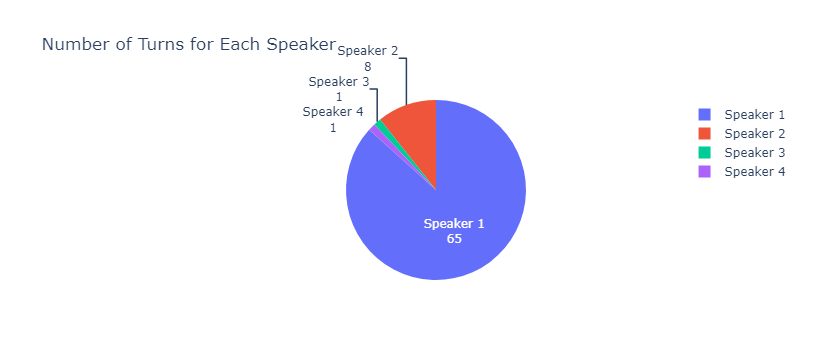

In [16]:
# Create the pie chart for number of turns
fig = go.Figure(data=[go.Pie(labels=speaker_turns.index, values=speaker_turns, name="Number of Turns")])
fig.update_traces(textinfo='value+label')
fig.update_layout(title_text='Number of Turns for Each Speaker')
fig.show()


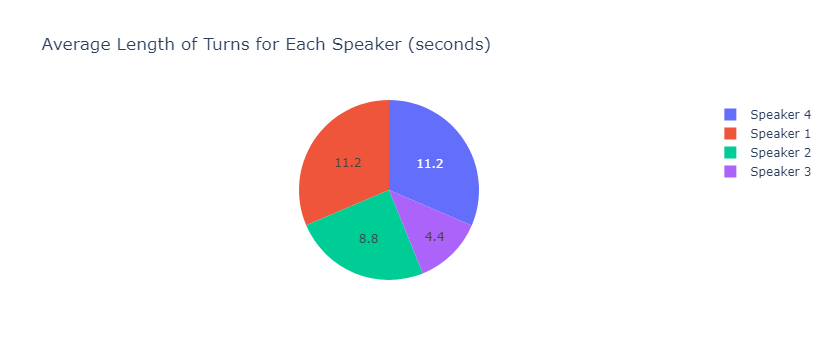

In [19]:
# Create the pie chart for average turn length
fig = go.Figure(data=[go.Pie(labels=speaker_avg_turns.index, values=speaker_avg_turns, name="Average Turn Length")])
fig.update_traces(textinfo='value+label', texttemplate='%{value:.1f}')
fig.update_layout(title_text='Average Length of Turns for Each Speaker (seconds)')
fig.show()

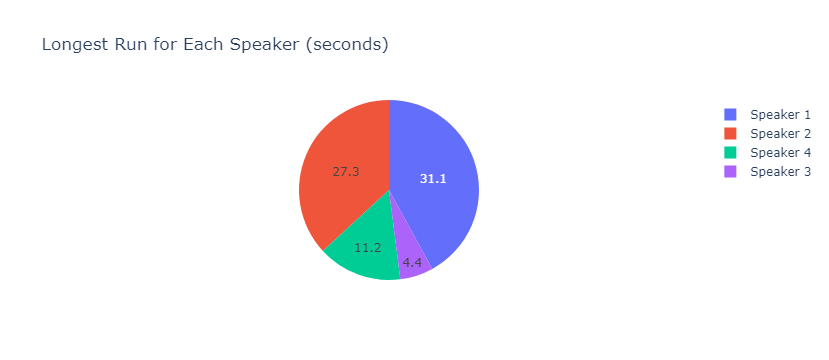

In [20]:
# Create the pie chart for longest run
fig = go.Figure(data=[go.Pie(labels=speaker_longest_run.index, values=speaker_longest_run, name="Longest Run")])
fig.update_traces(textinfo='value+label', texttemplate='%{value:.1f}')
fig.update_layout(title_text='Longest Run for Each Speaker (seconds)')
fig.show()

Sentiment Analysis

In [4]:
import spacy
from nltk.sentiment import SentimentIntensityAnalyzer
from vtt_formatting import df
import nltk

# Download the required NLTK data
nltk.download('vader_lexicon')

# Load the SpaCy model
nlp = spacy.load("en_core_web_sm")

# Initialize the sentiment analyzer
sia = SentimentIntensityAnalyzer()

# Define a list of pronouns referring to the other person
other_person_pronouns = ["you", "your", "yours", "yourself"]

# Set the boundary score for potential conflicts
boundary_score = -0.1

def sentiment(turn):
	# Analyze each turn in the conversation
	scores = sia.polarity_scores(turn)

	# Check for potential conflicts based on the compound score
	# if scores['compound'] < boundary_score:
	# 	print(f"Potential conflict detected: {turn}")

	# Check for negative sentiment towards the other person
	for pronoun in other_person_pronouns:
		if pronoun in turn.lower():
			if scores['compound'] < boundary_score:
				print(f"Negative sentiment towards the other person detected: {turn}" + "\n")
				break

for turn in df.Text:
    sentiment(turn)


Formatted .vtt file saved as 'data/formatted_output.vtt'.



[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


Negative sentiment towards the other person detected: Who talks about stakeholders? She has ruined Julius and Venu all mentioned stakeholders, who clearly is a topic that's important, you know, and we talked about conflict. General talked about conflict. So, you know, gives you a way to navigate and get some sense of what we're talking about.

Negative sentiment towards the other person detected: You can see where this is going and it's tagged properly, so the tagging methods so you see that I ask you, can you put this in the box? So can you move that box? Because if it is in one box, it will absorb the tag. Think about the work that we do reference mapping standard mappings for any data managing or P&L V PSHIP mapping. This is an analogy of that because if you don't have a good mapping, you can't do these kind of things. If you can take this kind of information.

Negative sentiment towards the other person detected: And you tell people one idea per sticky. You remember I said that bec

Generate the summary of the meeting

In [5]:
from transformers import BartForConditionalGeneration, BartTokenizer
# from vtt_formatting import df

# Load the BART-large-cnn model and tokenizer
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')

def summarize_text(df, max_chunk_length=600, max_summary_length=100):
    
    # Divide the text into chunks based on paragraphs or full stops, ensuring each chunk is within token limits
    # paragraphs = text.split('</v>')  # Assuming paragraphs are separated by new lines
    chunk_texts = []
    current_chunk = ""

    for turn in df.Text:
        if len(tokenizer(current_chunk + turn)) > max_chunk_length:
            chunk_texts.append(current_chunk)
            # print(current_chunk)
            # print()
            current_chunk = turn
        else:
            current_chunk += ' ' + turn
    if current_chunk:
        chunk_texts.append(current_chunk)

    # print(chunk_texts)

    # Summarize each chunk
    summaries = []
    for chunk in chunk_texts:
        input_ids = tokenizer.encode(chunk, return_tensors="pt", truncation=True, max_length=max_chunk_length)
        summary_ids = model.generate(input_ids, max_length=max_summary_length, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
        summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
        summaries.append(summary)

    # Combine the summaries
    full_summary = ' '.join(summaries)
    return full_summary

# Example usage:

summary = summarize_text(df)
print(summary)


Token indices sequence length is longer than the specified maximum sequence length for this model (1026 > 1024). Running this sequence through the model will result in indexing errors


 Analytics and the mental level analytics is not about making a report. It's about asking great questions and questions that matter what the business. So think about analytics perspective. How did he do this? It took a lot of effort from Z flying about trying to make arrows and connecting it.
